<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obiettivo
L'obiettivo di questo notebook è quello di focalizzarsi sugli embeddings che vengono prodotti dalla GNN al fine di comprendere se quest'ultima stia effettivamente producendo degli embeddings rappresentativi e differenziati tra i nodi.


Per farlo ho aggiunto un metodo alla classe di model per fare in modo che si effettui la stessa computazione effettuata da forward, ma senza l'applicazione della MLP finale, ma resitutendo invece gli embeddings generati dalla gnn. Questi embedding sono poi stati proiettati su due dimensioni tramite la tecnica della PCA per vedere la separabilità degli embeddings.

~~~python
def get_gnn_embeddings(self, batch: HeteroData, entity_table: NodeType) -> Tensor:
    seed_time = batch[entity_table].seed_time
    x_dict = self.encoder(batch.tf_dict)

    rel_time_dict = self.temporal_encoder(
        seed_time, batch.time_dict, batch.batch_dict
    )
    for node_type, rel_time in rel_time_dict.items():
        x_dict[node_type] = x_dict[node_type] + rel_time

    for node_type, embedding in self.embedding_dict.items():
        x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

    x_dict = self.gnn(
        x_dict,
        batch.edge_index_dict,
        batch.num_sampled_nodes_dict,
        batch.num_sampled_edges_dict,
    )

    return x_dict[entity_table][: seed_time.size(0)]  # <--- questi sono gli embedding della GNN

~~~

# Libraries to install

In [1]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

# Import

In [2]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#Utility functions

In [3]:
@torch.no_grad()
def alignment_check(loader: NeighborLoader, expected_node_ids: torch.Tensor):
    node_id_list = []

    for batch in loader:
        batch = batch.to(device)

        node_id_list.append(batch[task.entity_table].n_id.cpu())

    actual_node_ids = torch.cat(node_id_list, dim=0)

    assert len(actual_node_ids) == len(expected_node_ids), "Mismatch nella lunghezza"

    if not torch.equal(actual_node_ids, expected_node_ids):
        raise ValueError("Ordine dei nodi predetti diverso da val_table!")

    return

In [4]:
def evaluate_performance(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""
    target = target_table.df[task.target_col].to_numpy()

    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [5]:
import numpy as np

def evaluate_on_train_during_training() -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader_dict["train"]:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
        target_list.append(batch[task.entity_table].y.detach().cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    mae = np.mean(np.abs(pred_all - target_all))
    return mae


In [6]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2))

In [7]:
@torch.no_grad()
def evaluate_on_full_train(model, loader) -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.cpu())
        target_list.append(batch[task.entity_table].y.cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    mae = np.mean(np.abs(pred_all - target_all))
    return mae


In [8]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): Quanto aspettare senza miglioramenti prima di fermare.
            delta (float): Miglioramento minimo richiesto per considerare un miglioramento.
            verbose (bool): Se stampare informazioni.
            path (str): Dove salvare il modello migliore.
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.verbose = verbose
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss  # Perché vogliamo MINIMIZZARE la loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Salva il modello migliore'''
        if self.verbose:
            print(f'Validation loss migliorata ({self.val_loss_min:.6f} --> {val_loss:.6f}). Salvo modello...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Dataset and task creation

In [9]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train") #date  driverId  qualifying
val_table = task.get_table("val") #date  driverId  qualifying
test_table = task.get_table("test") # date  driverId

out_channels = 1
loss_fn = L1Loss()
# this is the mae loss and is used when have regressions tasks.
tune_metric = "mae"
higher_is_better = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db() #get all tables
col_to_stype_dict = get_stype_proposal(db)
entity_table = task.entity_table
#this is used to get the stype of the columns

cuda
Loading Database object from /root/.cache/relbench/rel-f1/db...
Done in 0.07 seconds.


In [10]:
list(db.table_dict.keys())

['standings',
 'constructor_results',
 'constructor_standings',
 'constructors',
 'qualifying',
 'results',
 'circuits',
 'races',
 'drivers']

# Embedder

In [11]:
class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
      try:
          path = "glove.6B.300d.txt"
          with open(path, encoding="utf-8") as f:
              for line in f:
                  parts = line.strip().split()
                  word = parts[0]
                  vector = np.array(parts[1:], dtype=np.float32)
                  self.embeddings[word] = vector
          #print(f"Loaded {len(self.embeddings)} GloVe embeddings.")
      except Exception as e:
          print(f"Failed to load GloVe: {e}")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                #print("non trovato")
                #print(f"Numero parole in embedding: {len(self.embeddings)}")

                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [12]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

# data, col_stats_dict = make_pkey_fkey_graph(
#     db,
#     col_to_stype_dict=col_to_stype_dict,
#     text_embedder_cfg=text_embedder_cfg,
#     cache_dir=os.path.join(
#         root_dir, f"rel-f1_materialized_cache"
#     ),
# )

Failed to load GloVe: [Errno 2] No such file or directory: 'glove.6B.300d.txt'


# Graph Loader

In [13]:
# qui i parametri di train_table, val_table, test_table, task e data sono
#parametri globali

def loader_dict_fn(batch_size, num_neighbours, data):
    loader_dict = {}

    for split, table in [
        ("train", train_table),
        ("val", val_table),
        ("test", test_table),
    ]:
        table_input = get_node_train_table_input(
            table=table,
            task=task,
        )

        loader_dict[split] = NeighborLoader(
            data,
            num_neighbors=[num_neighbours for _ in range(2)],
            time_attr="time",
            input_nodes=table_input.nodes,
            input_time=table_input.time,
            transform=table_input.transform,
            batch_size=batch_size,
            temporal_strategy="uniform",
            shuffle=split == "train",
            num_workers=0,
            persistent_workers=False,
        )

    return loader_dict


# Model

In [14]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData,
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        shallow_list: List[NodeType] = [],
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )

        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )

        self.gnn = HeteroGraphSAGE(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=1, ###################################################
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )

        return self.head(x_dict[entity_table][: seed_time.size(0)])

    def get_gnn_embeddings(self, batch: HeteroData, entity_table: NodeType) -> Tensor:
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )
        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )

        return x_dict[entity_table][: seed_time.size(0)]  # <--- questi sono gli embedding della GNN


    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])

# Training functions

Ora necessito di modificare la funzione di train per prendere anche il valore del loader_dict: utile per tuning dei parametri (vedi il codice della funzione di tuning).

In [15]:
def train(model, optimizer, loader_dict) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
        # embeddings = model(batch, task.entity_table).detach().cpu().numpy()
        # # Statistiche semplici
        # import numpy as np
        # print("Mean:", np.mean(embeddings, axis=0))
        # print("Std dev:", np.std(embeddings, axis=0))

        pred = pred.view(-1) if pred.size(1) == 1 else pred

        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [16]:
print(task.target_col)

position


## Scheduler tuning

In [17]:
import torch
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, ReduceLROnPlateau, OneCycleLR


def get_scheduler(name, optimizer, loader_len, epochs):
    if name == "cosine":
        return CosineAnnealingLR(optimizer, T_max=epochs)

    elif name == "linear_warmup":
        def lr_lambda(epoch):
            warmup_epochs = 5
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return max(0.1, 1 - (epoch - warmup_epochs) / (epochs - warmup_epochs))
        return LambdaLR(optimizer, lr_lambda=lr_lambda)

    elif name == "plateau":
        return ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, verbose=True)

    elif name == "onecycle":
        return OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=loader_len, epochs=epochs)

    else:
        raise ValueError(f"Unknown scheduler: {name}")


def evaluate_scheduler(scheduler_name, model_init_fn, loader_dict_fn, train_fn, test_fn,
                        evaluate_fn, task, val_table, epochs, device):
    model = model_init_fn().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
    loader_dict = loader_dict_fn()
    scheduler = get_scheduler(scheduler_name, optimizer, len(loader_dict["train"]), epochs)

    for epoch in range(epochs):
        train_fn(model, optimizer, loader_dict)
        if scheduler_name == "plateau":
            val_pred = test_fn(model, loader_dict["val"])
            val_mae = evaluate_fn(val_pred, val_table, task.metrics)["mae"]
            scheduler.step(val_mae)
        elif scheduler_name == "onecycle":
            # Step per batch
            for _ in loader_dict["train"]:
                scheduler.step()
        else:
            scheduler.step()

    val_pred = test_fn(model, loader_dict["val"])
    val_mae = evaluate_fn(val_pred, val_table, task.metrics)["mae"]
    return val_mae


def compare_schedulers(model_init_fn, loader_dict_fn, train_fn, test_fn,
                        evaluate_fn, task, val_table, epochs, device):
    schedulers = ["cosine", "linear_warmup", "plateau", "onecycle"]
    results = {}

    for name in schedulers:
        print(f"Testing scheduler: {name}")
        val_mae = evaluate_scheduler(name, model_init_fn, loader_dict_fn, train_fn, test_fn,
                                     evaluate_fn, task, val_table, epochs, device)
        results[name] = val_mae
        print(f"{name} val_mae: {val_mae:.4f}")

    best_scheduler = min(results, key=results.get)
    print(f"\nBest scheduler: {best_scheduler} (val_mae: {results[best_scheduler]:.4f})")
    return results


In [18]:
# compare_schedulers(
#     model_init_fn=lambda: Model(
#             data=data,
#             col_stats_dict=col_stats_dict,
#             num_layers=2,
#             channels=128,
#             out_channels=1,
#             aggr="max",
#             norm="batch_norm",
#     ).to(device),
#     loader_dict_fn=lambda: loader_dict_fn(batch_size=512, num_neighbours=256, data=data),
#     train_fn=train,
#     test_fn=test,
#     evaluate_fn=evaluate_performance,
#     task=task,
#     val_table=val_table,
#     epochs=50,
#     device=device
# )


Il migliore scheduler è quindi cosine:

Best scheduler: cosine (val_mae: 2.9038)
{'cosine': 2.9038224850325243,
 'linear_warmup': 2.915358568750865,
 'plateau': 3.30474050643847,
 'onecycle': 3.1991489658215557}

# Ablation on tables

In [19]:
def build_graph_excluding_tables(dataset, tables_to_remove, root_dir, text_embedder_cfg):
    import copy
    from relbench.modeling.graph import make_pkey_fkey_graph

    # 1. Deepcopy del db originale
    original_db = dataset.get_db()
    db = copy.deepcopy(original_db)

    # 2. Rimuovi tutte le tabelle
    for table_to_remove in tables_to_remove:
        if table_to_remove in db.table_dict:
            del db.table_dict[table_to_remove]

    # 3. Rimuovi fkey che puntano a tabelle escluse
    for table in db.table_dict.values():
        table.fkey_col_to_pkey_table = {
            col: tgt for col, tgt in table.fkey_col_to_pkey_table.items()
            if tgt not in tables_to_remove
        }
        # Rimuoviamo anche le colonne fkey nei df
        table.df = table.df.drop(
            columns=[
                col for col, tgt in table.fkey_col_to_pkey_table.items()
                if tgt not in db.table_dict
            ],
            errors="ignore"
        )

    # 4. Filtra anche lo stype
    full_stype = get_stype_proposal(original_db)
    filtered_stype = {
        tab: stype for tab, stype in full_stype.items()
        if tab not in tables_to_remove
    }

    # 5. Costruzione del grafo UNA sola volta
    cache_name = "_".join(sorted(tables_to_remove))
    data, col_stats_dict = make_pkey_fkey_graph(
        db,
        col_to_stype_dict=filtered_stype,
        text_embedder_cfg=text_embedder_cfg,
        cache_dir=os.path.join(root_dir, f"ablation_cache_{cache_name}")
    )

    all_tables = list(db.table_dict.keys())
    print(f"Tabelle rimanenti nel grafo: {all_tables}")

    return data, col_stats_dict, db


# Ablation on features

## Main results

Features essenziali:


| Tabella     | Feature         | MAE  | ΔMAE (≈) | Impatto        |
| ----------- | --------------- | ---- | -------- | -------------- |
| `results`   | `positionOrder` | 3.95 | +0.08    |  **Critica** |
| `standings` | `position`      | 3.89 | +0.02    |  Utile       |
| `races`     | `round`         | 3.88 | +0.01    |  Utile       |


Features meno importanti:


| Tabella        | Feature          | MAE    | ΔMAE (≈) | Impatto         |
| -------------- | ---------------- | ------ | -------- | --------------- |
| `constructors` | `constructorRef` | 3.8499 | −0.02    | Forse rumore |
| `races`        | `name`           | 3.8516 | −0.02    | Inutile      |
| `circuits`     | `lng`            | 3.8527 | −0.02    | Inutile      |


results.positionOrder è la feature più importante del dataset.

Feature come position, round, points... contribuiscono sensibilmente.

Alcune feature testuali o descrittive (name, location, constructorRef) non aiutano, e anzi potrebbero essere rumorose.



## Function for removing features

In [20]:
import copy
import os
from relbench.modeling.graph import make_pkey_fkey_graph

def get_graph_without_features(db, features_to_remove, root_dir, text_embedder_cfg):
    """
    Rimuove un insieme di feature specificate da diverse tabelle e restituisce il grafo aggiornato.

    :param dataset: Il dataset originale (oggetto relbench)
    :param features_to_remove: Lista di tuple (table_name, feature_name)
    :param root_dir: Cartella cache
    :param text_embedder_cfg: Configurazione dell'embedding testuale
    :return: (data, col_stats_dict)
     """
    # db_original = dataset.get_db()
    # db = copy.deepcopy(db_original)

    # Rimuove le feature indicate
    for table_name, feature in features_to_remove:
        if table_name in db.table_dict:
            table = db.table_dict[table_name]
            if feature in table.df.columns:
                table.df = table.df.drop(columns=[feature])
        else:
          print(f"feature {feature}  di tabella {table_name} non presente")

    # Ricostruisce lo stype_dict aggiornato
    stype_dict = get_stype_proposal(db)

    # Costruzione grafo aggiornato
    cache_name = "__".join([f"{t}_{f}" for t, f in features_to_remove])
    data, col_stats_dict = make_pkey_fkey_graph(
        db,
        col_to_stype_dict=stype_dict,
        text_embedder_cfg=text_embedder_cfg,
        cache_dir=os.path.join(root_dir, f"feature_ablation_cache_{cache_name}")
    )

    return data, col_stats_dict


# Embedding Analysis and Main



In [21]:
print(f"Testing without table: circuits and constructor_result")
tables_to_remove = ["circuits","constructor_results"]

data, col_stats_dict, db = build_graph_excluding_tables(
        dataset, tables_to_remove=tables_to_remove,
        root_dir=root_dir,
        text_embedder_cfg=text_embedder_cfg
)

loader_dict = loader_dict_fn(batch_size=512, num_neighbours=256, data=data)


Testing without table: circuits and constructor_result


/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-pac

Tabelle rimanenti nel grafo: ['standings', 'constructor_standings', 'constructors', 'qualifying', 'results', 'races', 'drivers']


In [22]:
features_to_remove = [
    ("constructors", "constructorRef"),
    ("constructors", "name"),
    ("races", "name"),
    ("circuits", "lat"),#vediamo se non presente
    ("circuits", "lng"),#idem
    ("drivers", "forename"),
    ("drivers", "driverRef"),
    ("drivers", "nationality"),
    ("constructor_standings", "wins"),
    ("results", "laps"),
    ("results", "points")
]

data, col_stats_dict = get_graph_without_features(db, features_to_remove, root_dir, text_embedder_cfg)


feature lat  di tabella circuits non presente
feature lng  di tabella circuits non presente


/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-packages/torch_frame/utils/io.py:113: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
/usr/local/lib/python3.11/dist-pac

In [23]:
loader_dict = loader_dict_fn(batch_size=512, num_neighbours=256, data=data)

model = Model(
        data=data,
        col_stats_dict=col_stats_dict,
        num_layers=2,
        channels=128,
        out_channels=1,
        aggr="max",
        norm="batch_norm",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)


epochs = 70

scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

early_stopping = EarlyStopping(
    patience=30,
    delta=0.0,
    verbose=True,
    path="best_basic_model.pt"
)


state_dict = None
test_table = task.get_table("test", mask_input_cols=False)
best_val_metric = -math.inf if higher_is_better else math.inf
best_test_metric = -math.inf if higher_is_better else math.inf


for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, loader_dict=loader_dict)

    train_pred = test(model, loader_dict["train"])
    train_metrics = evaluate_performance(train_pred, train_table, task.metrics)
    train_mae_preciso = evaluate_on_full_train(model, loader_dict["train"])

    val_pred = test(model, loader_dict["val"])
    val_metrics = evaluate_performance(val_pred, val_table, task.metrics)

    test_pred = test(model, loader_dict["test"])
    test_metrics = evaluate_performance(test_pred, test_table, task.metrics)

    scheduler.step(val_metrics[tune_metric])

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())

    #test:
    if (higher_is_better and test_metrics[tune_metric] > best_test_metric) or (
            not higher_is_better and test_metrics[tune_metric] < best_test_metric
    ):
        best_test_metric = test_metrics[tune_metric]
        state_dict_test = copy.deepcopy(model.state_dict())

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch:02d}, Train mae: {train_mae_preciso:.2f}, Validation MAE: {val_metrics[tune_metric]:.2f}, Test MAE: {test_metrics[tune_metric]:.2f}, LR: {current_lr:.6f}")

    early_stopping(val_metrics[tune_metric], model)

    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break
print(f"best validation results: {best_val_metric}")
print(f"best test results: {best_test_metric}")

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 01, Train mae: 10.13, Validation MAE: 7.34, Test MAE: 8.20, LR: 0.000487
Validation loss migliorata (inf --> 7.337237). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 02, Train mae: 9.65, Validation MAE: 6.85, Test MAE: 7.67, LR: 0.000488
Validation loss migliorata (7.337237 --> 6.853810). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 03, Train mae: 9.23, Validation MAE: 6.46, Test MAE: 7.26, LR: 0.000490
Validation loss migliorata (6.853810 --> 6.457523). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 04, Train mae: 8.83, Validation MAE: 6.08, Test MAE: 6.87, LR: 0.000491
Validation loss migliorata (6.457523 --> 6.084878). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 05, Train mae: 8.43, Validation MAE: 5.72, Test MAE: 6.52, LR: 0.000492
Validation loss migliorata (6.084878 --> 5.724492). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.02it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 06, Train mae: 8.06, Validation MAE: 5.39, Test MAE: 6.18, LR: 0.000493
Validation loss migliorata (5.724492 --> 5.393444). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 07, Train mae: 7.70, Validation MAE: 5.09, Test MAE: 5.87, LR: 0.000493
Validation loss migliorata (5.393444 --> 5.092511). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.04it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 08, Train mae: 7.37, Validation MAE: 4.82, Test MAE: 5.57, LR: 0.000494
Validation loss migliorata (5.092511 --> 4.821232). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 09, Train mae: 7.05, Validation MAE: 4.59, Test MAE: 5.30, LR: 0.000495
Validation loss migliorata (4.821232 --> 4.585912). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10, Train mae: 6.78, Validation MAE: 4.39, Test MAE: 5.07, LR: 0.000495
Validation loss migliorata (4.585912 --> 4.387028). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 11, Train mae: 6.54, Validation MAE: 4.22, Test MAE: 4.86, LR: 0.000496
Validation loss migliorata (4.387028 --> 4.220078). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.03it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 12, Train mae: 6.33, Validation MAE: 4.10, Test MAE: 4.70, LR: 0.000496
Validation loss migliorata (4.220078 --> 4.096905). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 13, Train mae: 6.15, Validation MAE: 4.00, Test MAE: 4.56, LR: 0.000496
Validation loss migliorata (4.096905 --> 3.998843). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.06it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 14, Train mae: 6.00, Validation MAE: 3.92, Test MAE: 4.46, LR: 0.000496
Validation loss migliorata (3.998843 --> 3.922537). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 15, Train mae: 5.87, Validation MAE: 3.87, Test MAE: 4.39, LR: 0.000496
Validation loss migliorata (3.922537 --> 3.870828). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  6.01it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 16, Train mae: 5.78, Validation MAE: 3.85, Test MAE: 4.34, LR: 0.000496
Validation loss migliorata (3.870828 --> 3.853378). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 17, Train mae: 5.70, Validation MAE: 3.86, Test MAE: 4.31, LR: 0.000496
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 18, Train mae: 5.65, Validation MAE: 3.87, Test MAE: 4.30, LR: 0.000496
EarlyStopping counter: 2 / 30


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 19, Train mae: 5.61, Validation MAE: 3.89, Test MAE: 4.30, LR: 0.000496
EarlyStopping counter: 3 / 30


100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 20, Train mae: 5.59, Validation MAE: 3.90, Test MAE: 4.30, LR: 0.000496
EarlyStopping counter: 4 / 30


100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 21, Train mae: 5.56, Validation MAE: 3.89, Test MAE: 4.28, LR: 0.000496
EarlyStopping counter: 5 / 30


100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 22, Train mae: 5.53, Validation MAE: 3.74, Test MAE: 4.16, LR: 0.000496
Validation loss migliorata (3.853378 --> 3.743106). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.78it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 23, Train mae: 5.36, Validation MAE: 3.53, Test MAE: 3.91, LR: 0.000497
Validation loss migliorata (3.743106 --> 3.527265). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 24, Train mae: 5.26, Validation MAE: 3.46, Test MAE: 3.82, LR: 0.000497
Validation loss migliorata (3.527265 --> 3.464227). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 25, Train mae: 5.18, Validation MAE: 3.35, Test MAE: 3.76, LR: 0.000497
Validation loss migliorata (3.464227 --> 3.353596). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 26, Train mae: 5.05, Validation MAE: 3.16, Test MAE: 3.86, LR: 0.000497
Validation loss migliorata (3.353596 --> 3.162833). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.92it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 27, Train mae: 5.05, Validation MAE: 3.15, Test MAE: 4.19, LR: 0.000498
Validation loss migliorata (3.162833 --> 3.148621). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 28, Train mae: 4.94, Validation MAE: 3.13, Test MAE: 3.88, LR: 0.000498
Validation loss migliorata (3.148621 --> 3.125370). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 29, Train mae: 4.87, Validation MAE: 2.92, Test MAE: 4.07, LR: 0.000498
Validation loss migliorata (3.125370 --> 2.924060). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.95it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 30, Train mae: 4.84, Validation MAE: 2.87, Test MAE: 4.20, LR: 0.000498
Validation loss migliorata (2.924060 --> 2.866204). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 31, Train mae: 4.81, Validation MAE: 2.97, Test MAE: 4.32, LR: 0.000498
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 32, Train mae: 4.75, Validation MAE: 2.95, Test MAE: 4.29, LR: 0.000498
EarlyStopping counter: 2 / 30


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 33, Train mae: 4.78, Validation MAE: 3.06, Test MAE: 4.35, LR: 0.000498
EarlyStopping counter: 3 / 30


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 34, Train mae: 4.62, Validation MAE: 2.98, Test MAE: 4.12, LR: 0.000498
EarlyStopping counter: 4 / 30


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 35, Train mae: 4.61, Validation MAE: 2.97, Test MAE: 4.20, LR: 0.000498
EarlyStopping counter: 5 / 30


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 36, Train mae: 4.56, Validation MAE: 2.90, Test MAE: 4.27, LR: 0.000498
EarlyStopping counter: 6 / 30


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 37, Train mae: 4.57, Validation MAE: 2.93, Test MAE: 4.32, LR: 0.000498
EarlyStopping counter: 7 / 30


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 38, Train mae: 4.48, Validation MAE: 2.91, Test MAE: 4.39, LR: 0.000498
EarlyStopping counter: 8 / 30


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 39, Train mae: 4.61, Validation MAE: 3.10, Test MAE: 4.26, LR: 0.000498
EarlyStopping counter: 9 / 30


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 40, Train mae: 4.50, Validation MAE: 3.02, Test MAE: 4.20, LR: 0.000498
EarlyStopping counter: 10 / 30


100%|██████████| 15/15 [00:02<00:00,  5.99it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 41, Train mae: 4.38, Validation MAE: 2.91, Test MAE: 4.28, LR: 0.000498
EarlyStopping counter: 11 / 30


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 42, Train mae: 4.35, Validation MAE: 3.07, Test MAE: 4.16, LR: 0.000498
EarlyStopping counter: 12 / 30


100%|██████████| 15/15 [00:02<00:00,  5.98it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 43, Train mae: 4.47, Validation MAE: 3.06, Test MAE: 4.46, LR: 0.000498
EarlyStopping counter: 13 / 30


100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 44, Train mae: 4.27, Validation MAE: 2.90, Test MAE: 4.19, LR: 0.000498
EarlyStopping counter: 14 / 30


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 45, Train mae: 4.23, Validation MAE: 3.00, Test MAE: 4.21, LR: 0.000498
EarlyStopping counter: 15 / 30


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 46, Train mae: 4.20, Validation MAE: 3.02, Test MAE: 4.44, LR: 0.000498
EarlyStopping counter: 16 / 30


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 47, Train mae: 4.12, Validation MAE: 3.03, Test MAE: 4.54, LR: 0.000498
EarlyStopping counter: 17 / 30


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 48, Train mae: 4.06, Validation MAE: 3.03, Test MAE: 4.22, LR: 0.000498
EarlyStopping counter: 18 / 30


100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 49, Train mae: 3.92, Validation MAE: 3.01, Test MAE: 4.27, LR: 0.000498
EarlyStopping counter: 19 / 30


100%|██████████| 15/15 [00:02<00:00,  5.82it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 50, Train mae: 3.93, Validation MAE: 3.31, Test MAE: 4.42, LR: 0.000497
EarlyStopping counter: 20 / 30


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 51, Train mae: 3.86, Validation MAE: 3.16, Test MAE: 4.30, LR: 0.000497
EarlyStopping counter: 21 / 30


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 52, Train mae: 3.84, Validation MAE: 3.31, Test MAE: 4.48, LR: 0.000497
EarlyStopping counter: 22 / 30


100%|██████████| 15/15 [00:02<00:00,  5.40it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 53, Train mae: 3.76, Validation MAE: 3.24, Test MAE: 4.72, LR: 0.000497
EarlyStopping counter: 23 / 30


100%|██████████| 15/15 [00:02<00:00,  5.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 54, Train mae: 3.55, Validation MAE: 3.19, Test MAE: 4.25, LR: 0.000497
EarlyStopping counter: 24 / 30


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 55, Train mae: 3.49, Validation MAE: 3.15, Test MAE: 4.38, LR: 0.000498
EarlyStopping counter: 25 / 30


100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 56, Train mae: 3.69, Validation MAE: 3.13, Test MAE: 4.42, LR: 0.000498
EarlyStopping counter: 26 / 30


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 57, Train mae: 3.36, Validation MAE: 3.21, Test MAE: 4.41, LR: 0.000497
EarlyStopping counter: 27 / 30


100%|██████████| 15/15 [00:02<00:00,  6.00it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 58, Train mae: 3.42, Validation MAE: 3.47, Test MAE: 4.53, LR: 0.000497
EarlyStopping counter: 28 / 30


100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 59, Train mae: 3.26, Validation MAE: 3.28, Test MAE: 4.57, LR: 0.000497
EarlyStopping counter: 29 / 30


100%|██████████| 15/15 [00:02<00:00,  5.91it/s]


Epoch: 60, Train mae: 3.24, Validation MAE: 3.21, Test MAE: 4.55, LR: 0.000497
EarlyStopping counter: 30 / 30
Early stopping triggered at epoch 60
best validation results: 2.86620403078292
best test results: 3.758635973930359


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Adesso, sul modello trainato proviamo ad applicare la PCA analysis sulle features con m=2.

Questo test si pone come obiettivo quello di capire quanto informativi siano gli embedding appresi dal modello.

Se il PCA mostra che i nodi con target diversi non sono distinguibili, significa che:

O il grafo non contiene abbastanza segnale,

O il modello è troppo debole,

O le feature non sono sufficienti.

In [24]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


def plot_embedding_pca(model, loader, task, val_table, device):
    """
    Estrae gli embedding dal validation set e ne visualizza la proiezione PCA.
    I punti sono colorati in base al target (es. posizione del pilota).

    :param model: Modello addestrato
    :param loader: loader_dict["val"]
    :param task: oggetto task relbench
    :param val_table: tabella di validazione con colonna target
    :param device: CPU o CUDA
    """
    model.eval()
    embeddings = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            #emb = model(batch, task.entity_table)
            emb = model.get_gnn_embeddings(batch, task.entity_table)
            embeddings.append(emb.detach().cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()

    # PCA
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)

    # Target per colorare
    target_vals = val_table.df[task.target_col].values

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=target_vals, cmap="viridis", alpha=0.6)
    plt.colorbar(scatter, label="Target (e.g. position)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA degli embedding del validation set")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Lancio il test:

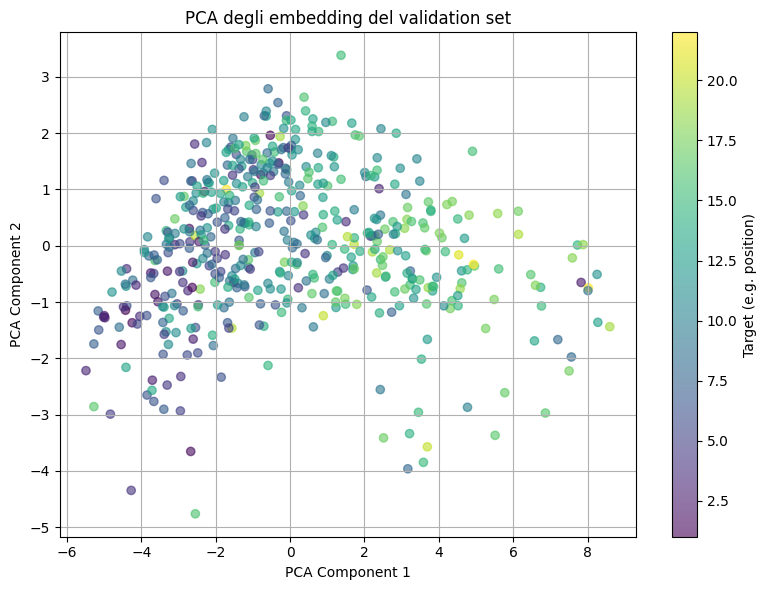

In [26]:
plot_embedding_pca(model, loader_dict["val"], task, val_table, device)

I punti sono i nodi target, ovvero i piloti. I colori rappresentano, per ogni pilota, la posizione target del pilota (ovvero il posto in classifica da predire).

La tecnica è quella di compressare la dimensionalità prodotta dalla gnn (128 channels) in solo due dimensioni.

L'obiettivo di questa analisi è vedere se nodi con target simili vengono mappate in aree vicini, ovvero presentano embeddings simili.

Noto che:
- i punti con posizione bassa (viola) tendono a stare in una zona diversa da quelli con posizione alta (giallo-verde).
- alcuni embedding di nodi con posizioni lontane sono molto simili. Quindi possiamo ancora migliorare.


Ricorda che quello che si vede qui sono gli embeddings che la gnn restituisce alla mlp: se sono poco significativi la mlp non potrà effettuare un buon task di regressione purtroppo. ci sono sovrapposizioni che potrebbero rendere difficile per la MLP finale distinguere casi simili.


Questo mi consente anche di dire che non è dal tuning della MLP che potremmo trarre vantaggi, perché il collo di bottiglia sta a monte: nella gnn.

Per verificare queste analisi procedo con un altro test: tsne.

In [27]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embedding_tsne(model, loader, task, val_table, device, perplexity=30):
    """
    Visualizza gli embedding prodotti dalla GNN usando t-SNE.
    """
    model.eval()
    embeddings = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            emb = model.get_gnn_embeddings(batch, task.entity_table)
            embeddings.append(emb.cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca")
    proj = tsne.fit_transform(embeddings)

    # Target
    target_vals = val_table.df[task.target_col].values

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=target_vals, cmap="viridis", alpha=0.6)
    plt.colorbar(scatter, label="Target (e.g. position)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE degli embedding della GNN (validation set)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


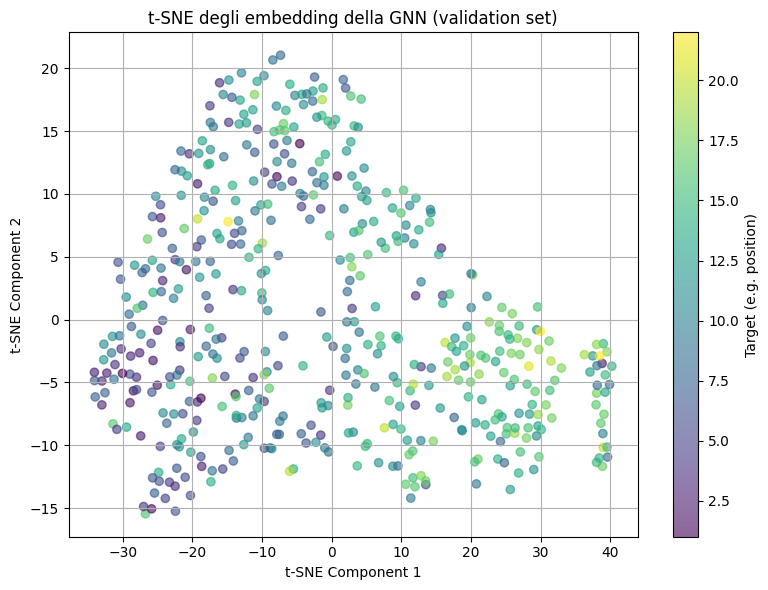

In [28]:
plot_embedding_tsne(model, loader_dict["val"], task, val_table, device)


| Aspetto                                                 | Interpretazione                                                        |
| ------------------------------------------------------- | ---------------------------------------------------------------------- |
| **Gradiente** visivo (sinistra scura, destra chiara) | La GNN ha appreso embedding **parzialmente correlati** al target.      |
| Colori mischiati localmente                          | Il modello **non distingue bene** tra posizioni simili (es. 3° vs 6°). |
| Nessun clustering netto                              | Gli embedding non sono **fortemente strutturati** secondo il ranking.  |


Questo t-SNE conferma che la GNN apprende qualcosa, ma non in modo molto discriminativo

Sono curioso di vedere quello che succede con il dataset di testing

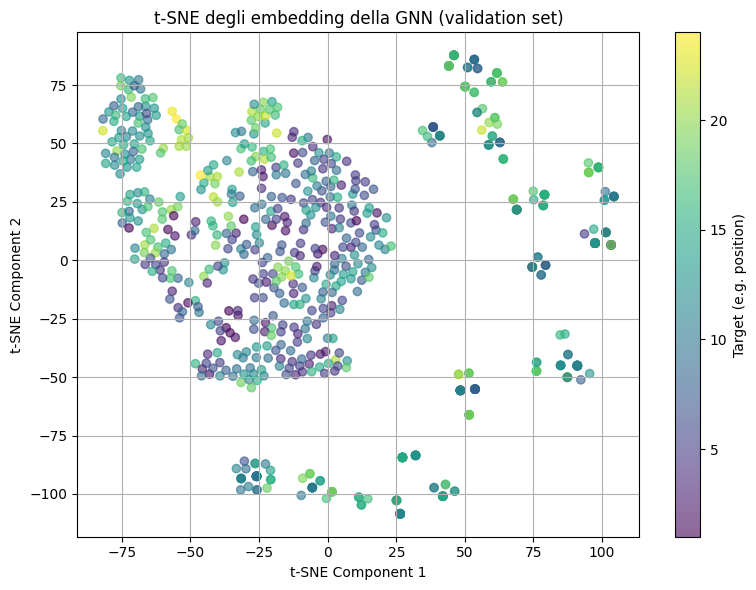

In [32]:
plot_embedding_tsne(model, loader_dict["test"], task, test_table, device)

Per il training ricorda che i dati sono attualmente "disordinati" (shuffle=True), quindi dobbiamo prima garantire la corrispondenza tra i nodi e le labels.

In [ ]:
@torch.no_grad()
def evaluate_on_full_train(model, loader) -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.cpu())
        target_list.append(batch[task.entity_table].y.cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    mae = np.mean(np.abs(pred_all - target_all))
    return mae


In [33]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embedding_tsne_train(model, loader, task, val_table, device, perplexity=30):
    """
    Visualizza gli embedding prodotti dalla GNN usando t-SNE.
    """
    model.eval()
    embeddings, target_list = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            emb = model.get_gnn_embeddings(batch, task.entity_table)
            embeddings.append(emb.cpu())
            target_list.append(batch[task.entity_table].y.cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    target_vals = torch.cat(target_list, dim=0).numpy()

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca")
    proj = tsne.fit_transform(embeddings)

    # Target
    #target_vals = val_table.df[task.target_col].values

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=target_vals, cmap="viridis", alpha=0.6)
    plt.colorbar(scatter, label="Target (e.g. position)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE degli embedding della GNN (validation set)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


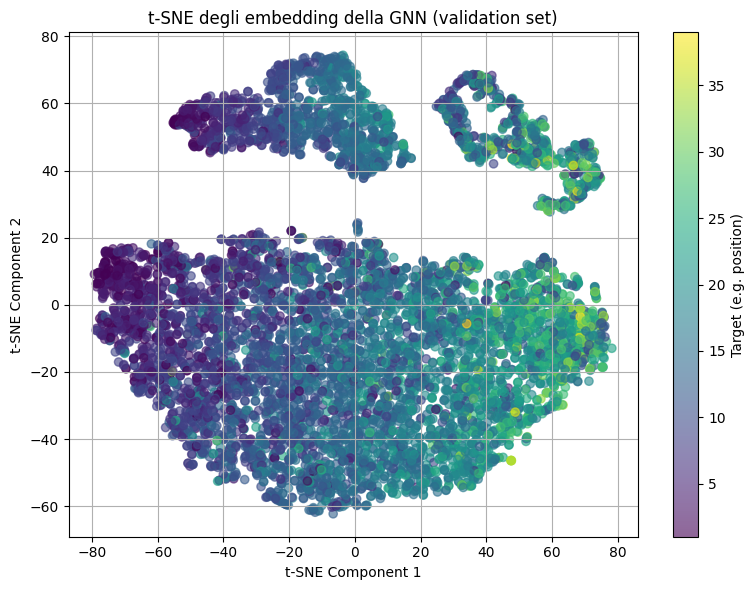

In [35]:
plot_embedding_tsne_train(model, loader_dict["train"], task, train_table, device)

Gli embedding della GNN contengono informazioni sul target: la rete ha appreso a strutturare il suo spazio latente in modo significativo rispetto al valore della posizione finale.

La transizione graduale dei colori (anziché una distribuzione casuale) è un buon segnale: indica che il modello sta differenziando in modo utile i nodi.

I cluster ben separati nella parte alta potrebbero indicare insiemi di nodi con caratteristiche molto simili o target molto distinti.

